# Plotting Streamfunctions

_Author: Aline Van Driessche_

This notebook contains all code needed to plot the visual representation supporting the streamfunction calculations. The needed input MOC streamfunctions and strength values can be reproduced with the other notebooks in the 'moc' folder (for ECCO) or in the 'access' folder (for ACCESS data). 

# Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean the actual visualisation code.

In [11]:
import os
import sys

import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from matplotlib import colors
norm=colors.TwoSlopeNorm(vcenter=0.)
from models.utils import *
from models.plotting_utils import *
import matplotlib.pyplot as plt

In [2]:
# Helper function to open a pickle streamfunction and format it as an xarray dataset
def read_streamfunction(strf_path, timesteps, invert_depths=True, Z=None):
    with open(strf_path, 'rb') as f:
        strf = pickle.load(f).astype(np.float64)

    print(strf.shape)
    if Z is None:
        ECCO_GRID = xr.open_dataset(paths.geom_fp)
        Z = ECCO_GRID.coords['Z'].data

    if invert_depths is True:
        strf = strf[::-1] #Invert the depth values
        
    if len(strf.shape) == 2: 
        strf = np.transpose(strf, (1,0)) 
    else:
        strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
        strf = np.transpose(strf, (2,0,1)).squeeze()
    strf = xr.Dataset(
            data_vars = {'moc' : (["time", "k"], strf)}, 
            coords = {'time' : timesteps,  'k': np.arange(strf.shape[1])}
            )
    
    strf = strf.assign_coords(Z=('k', Z))
    return strf

In [3]:
# Helper function to open a pickle moc strength file and format is as an xarray dataset
def read_moc_strength_dataset(moc_path, time_steps, invert_depths=True):
    with open(moc_path, 'rb') as f:
        moc = pickle.load(f).astype(np.float64)
    
    if invert_depths is True:
        moc = moc[::-1]
        
    moc = xr.Dataset(
        data_vars={'moc': (["time"], moc)},
        coords={'time': time_steps}
    )
    return moc

In [4]:
# A helper function to extract the streamfunction at the level (depth or density) where the moc is maximal in a southern (max) or northern direction (min)
def get_PSI_at_max_density_level(PSI, moc_param="psi_moc", max=True):
    PSI_mean = PSI[moc_param].mean("time")  # np.abs()
    if max is True:
        max_index = PSI_mean.argmax(dim="k")
    else:
        max_index = PSI_mean.argmin(dim="k")
    print(max_index)
    return PSI.isel(k=max_index)

In [5]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

## 1. Bolus versus Time-mean velocity

This graph shows how the bolus and time-mean velocity component both contribute to the final mean velocity. The individual streamfunction files can be calculated with 'sf_sl.ipynb', using a version with and without bolus component. 

In [6]:
# Replace these with the calculated streamfunctions as described above
OUTPUT_DIR = paths.STREAMFUNCTIONS_ECCO_OUTPUT

PSI_26 = xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_residual26.5N.nc"))
PSI_30 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_residual30S.nc"))
PSI_60 = xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_residual60S.nc"))
PSI_55 = xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_residual55S.nc"))

PSI_bol_26 = xr.open_dataset(os.path.join(OUTPUT_DIR, "26.5N", "PSI_bolus26.5N.nc"))
PSI_bol_30 = xr.open_dataset(os.path.join(OUTPUT_DIR, "30S", "PSI_bolus30S.nc"))
PSI_bol_55 = xr.open_dataset(os.path.join(OUTPUT_DIR, "55S", "PSI_bolus55S.nc"))
PSI_bol_60 = xr.open_dataset(os.path.join(OUTPUT_DIR, "60S", "PSI_bolus60S.nc"))

C:\Users\aline\AppData\Local\Temp\ipykernel_12036\3991176908.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


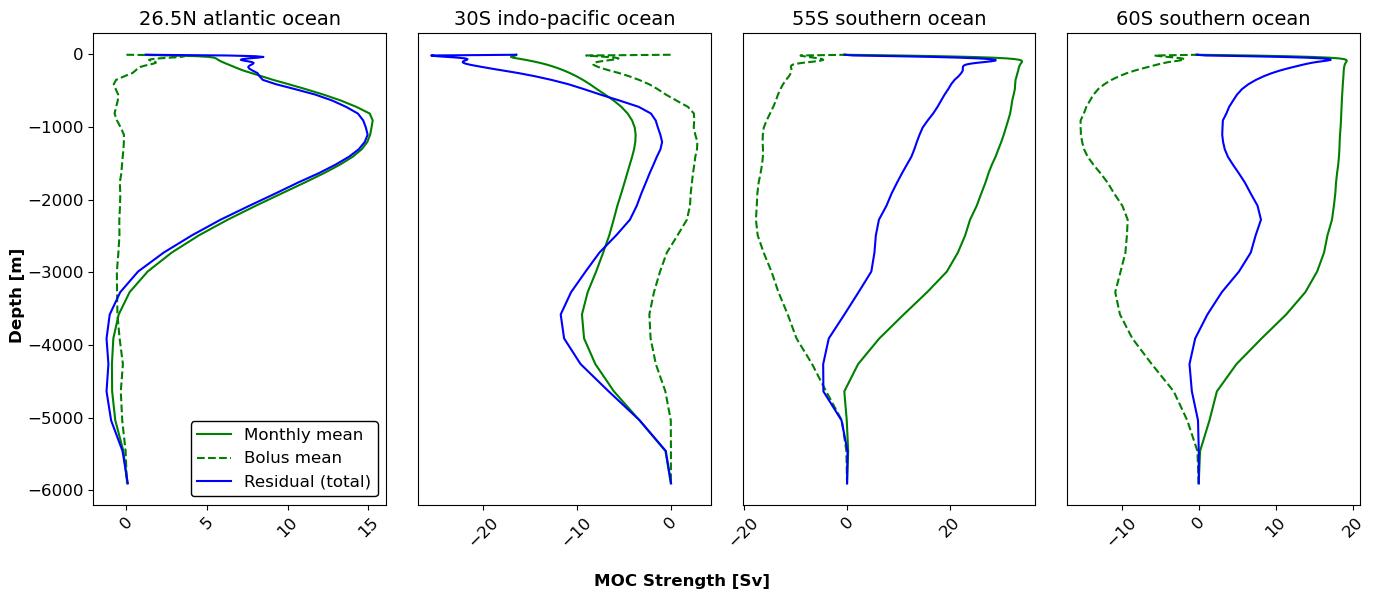

In [7]:
PSIs = [(PSI_26, PSI_bol_26), (PSI_30, PSI_bol_30), (PSI_55, PSI_bol_55), (PSI_60, PSI_bol_60)]
titles = ['26.5N atlantic ocean', '30S indo-pacific ocean', '55S southern ocean', '60S southern ocean']

fig = plt.figure(figsize=(14, 6), constrained_layout=True)
    
for index, PSI_tuple in enumerate(PSIs):
    
    PSI, PSI_bol = PSI_tuple
    
    plt.subplot(1, 4, index+1)
    plt.plot(PSI['psi_moc'].mean("time"), PSI["Z"], 
             color='green', label='Monthly mean')
    if PSI_bol is not None:
        plt.plot(PSI_bol['psi_moc'].mean("time"), PSI_bol["Z"], 
                 linestyle='--', color='green', label='Bolus mean')
        plt.plot(PSI_bol['psi_moc'].mean("time")+PSI['psi_moc'].mean("time"), PSI_bol["Z"],
                 linestyle='-', color='blue', label='Residual (total)')
    if index == 0:
        plt.legend(loc = 'lower right', edgecolor = 'black', framealpha = 1, fontsize=12)
    else:
        plt.gca().get_yaxis().set_visible(False)
    plt.title(titles[index], fontsize=14)
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=45)
fig.supxlabel("MOC Strength [Sv]", weight="bold")
fig.supylabel("Depth [m]", weight="bold")
plt.tight_layout()
plt.savefig(f"C:/Users/aline/OTP/plots/bolusvsresidual.png", dpi=400)
plt.show()

## 2. Depth vs. density 

This graph shows how the streamfunction plotted over time and depth space. We obtain the streamfunction in depth space at 30°S by using 'sf_sl.ipynb' (with 'use_density' = False), the moc_density in density space from 'sl_moc.ipynb', the ECCO grid is the original geometry file retrieved from the NASA PO.DAAC website and finally the inputs, which we use purely to match the timesteps with the streamfunction, are the ECCO satellite observable variables at 30°S, also retrieved from the NASA PO.DAAC website.

In [9]:
#Experiment variables 
lat = -30

ECCO_GRID = xr.open_dataset(paths.geom_fp)

strf_depth_path = f"{paths.LOCAL_DIR}/ecco_data_minimal/{format_lat_lon(lat)}_sf_depth.pickle"
moc_dens_path = f"{paths.LOCAL_DIR}/ecco_data_minimal/{format_lat_lon(lat)}_moc_density.pickle"

inputs = xr.open_dataset(f"{paths.LOCAL_DIR}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))

In [10]:
# Retrieve the moc strength at 30°S (AABW cell) in density space and the streamfunction in depth space 
moc_dens = read_moc_strength_dataset(moc_dens_path, inputs.time)
strf = read_streamfunction(strf_depth_path, inputs.time)

# Calculate the depth level for the DEPTH moc strength (1 value for the whole timeseries)
strf_comparison = strf.copy(deep=True)
strf_comparison['moc'].loc[dict(k=slice(0,20))] = 1e6
k_index = strf_comparison['moc'].mean("time").argmin(dim="k")
Z_depth = ECCO_GRID.coords['Z'].data[k_index]

# Calculate the depth levels for the DENSITY moc strength (different depth value for each density value)
difference = abs(strf_comparison - moc_dens.broadcast_like(strf_comparison))
min_diff_index = difference.argmin(dim='k')
closest_depths = strf.Z.isel(k=min_diff_index.moc.values)
closest_depths = closest_depths.rename({'k': 'time'})

(50, 312)


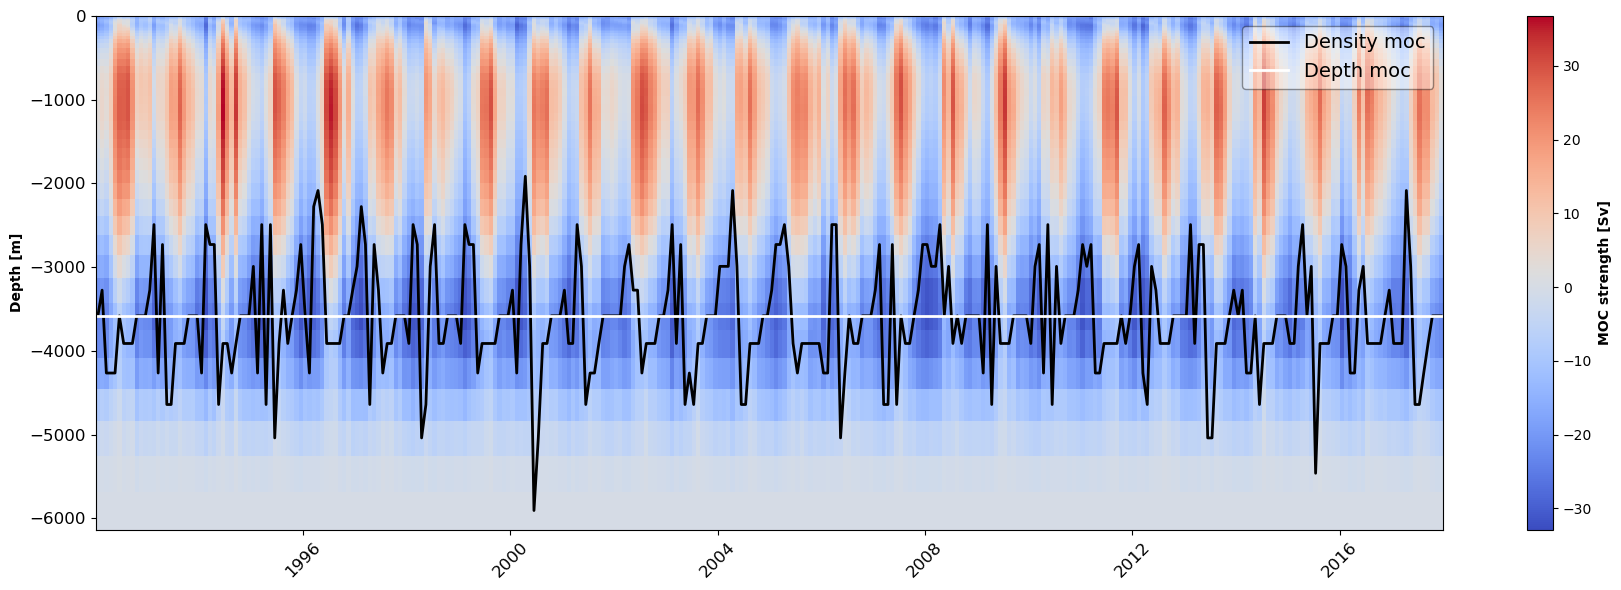

In [12]:
# Plot the streamfunction in depth space with the corresponding density -> depth levels
stf_ds = strf.squeeze()

fig = plt.figure(figsize=(18, 6))
plt.subplot(1, 1, 1) 
time_edge_extrap = np.hstack((
    stf_ds["time"].values[0] - (0.5 * np.diff(stf_ds["time"].values[0:2])),
    stf_ds["time"].values[:-1] + (0.5 * np.diff(stf_ds["time"].values)),
    stf_ds["time"].values[-1] + (0.5 * np.diff(stf_ds["time"].values[-2:])),
    ))
Z_edge_extrap = np.hstack((
    np.array([0]),
    stf_ds["Z"].values[:-1] + (0.5 * np.diff(stf_ds["Z"].values)),
    np.array([-6134.5]),
    ))
pcm = plt.pcolormesh(time_edge_extrap, Z_edge_extrap, stf_ds['moc'].T, shading='auto', cmap='coolwarm')
plt.ylabel("Depth [m]", weight="bold")
plt.tick_params(labelsize=12)
plt.xticks(rotation=45)
cb = plt.colorbar(pcm)
cb.set_label("MOC strength [Sv]", weight="bold")

plt.plot(stf_ds["time"].values, closest_depths, color='black', linestyle='-', linewidth=2.0, label='Density moc')
plt.axhline(y=Z_depth, color='white', linestyle='-', label='Depth moc', linewidth=2.0), 
plt.legend(edgecolor = 'black', framealpha = 0.4, fontsize=14)
plt.savefig(f"C:/Users/aline/OTP/plots/depth_vs_density.png", dpi=400)
plt.tight_layout()
plt.show()

## 3. ECCO vs ACCESS

The following plots compare the streamfunctions as calculated with ECCO data (native grid vs lat-lon space) and ACCESS data. The streamfunctions in this sections are all plotted in depth space. The ECCO moc strength in the native grid is obtained through 'streamfunction_LLC0090.ipynb' (in archive) and the ECCO moc strength in lat-lon space through 'sf_sl.ipynb' (in streamfunction) with 'use_density' = False. The ACCESS moc strength finally, is calculated with ...

 The ECCO grid is the original geometry file retrieved from the NASA PO.DAAC website and finally the inputs, which we use purely to match the timesteps with the streamfunction, are the ECCO satellite observable variables at 30°S, also retrieved from the NASA PO.DAAC website.

In [18]:
lat=-30
data_home = paths.LOCAL_DIR

# Streamfunction in ECCO and ACCESS (latlon) in depth space
strf_ecco_depth = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_atlantic_sf_depth.pickle"
moc_access = f"{data_home}/access_data/MOC_{format_lat_lon(lat)}_at.nc"

# Streamfunctions in native grid are calculated on bolus and monthly-mean component separately
PSI_mean = xr.open_dataset(os.path.join(paths.STREAMFUNCTIONS_ECCO_OUTPUT, f"{format_lat_lon(lat)}", f"PSI_atlantic_residual{format_lat_lon(lat)}.nc"))
PSI_bol = xr.open_dataset(os.path.join(paths.STREAMFUNCTIONS_ECCO_OUTPUT, f"{format_lat_lon(lat)}", f"PSI_atlantic_bolus{format_lat_lon(lat)}.nc"))

ECCO_GRID = xr.open_dataset(paths.geom_fp)
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))

In [19]:
# Load the ECCO (latlon) streamfunction in depth space 
strf = read_streamfunction(strf_ecco_depth, inputs.time, invert_depths=True)

# Calculate the AABW cell
strf_comparison = strf.copy(deep=True)
strf_comparison['moc'].loc[dict(k=slice(0,5))] = 0
moc_ecco_latlon = get_PSI_at_max_density_level(strf_comparison.squeeze(), moc_param='moc', max=False)

(50, 3, 312)
<xarray.DataArray 'moc' ()>
array(44)


In [20]:
# Load the ACCESS streamfunction in depth space
moc_access = xr.open_dataset(moc_access)
moc_access = moc_access.rename({'MOC': 'moc'})
for var_name in moc_access:
    moc_access[var_name] = moc_access[var_name] / 1e6

# Adjust the date range when working with ACCESS to the available ECCO data
date_range = (moc_ecco_latlon.time.values[0], moc_ecco_latlon.time.values[-1]) 
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
moc_ecco, moc_access = align_inputs_outputs(moc_ecco_latlon, moc_access, date_range = date_range, ecco=False)

Date range to align to: ('1992-01-16', '2017-12-16')


In [21]:
# Load the ECCO (native grid) streamfunction in depth space 
strf_native_ecco = PSI_mean + PSI_bol

# Calculate the AABW cell
strf_comparison = strf_native_ecco.copy(deep=True)
strf_comparison['psi_moc'].loc[dict(k=slice(0,5))] = 0
moc_ecco_native = get_PSI_at_max_density_level(strf_comparison.squeeze(), moc_param='psi_moc', max=False)-2

<xarray.DataArray 'psi_moc' ()>
array(44)
Coordinates:
    lat      int32 -30


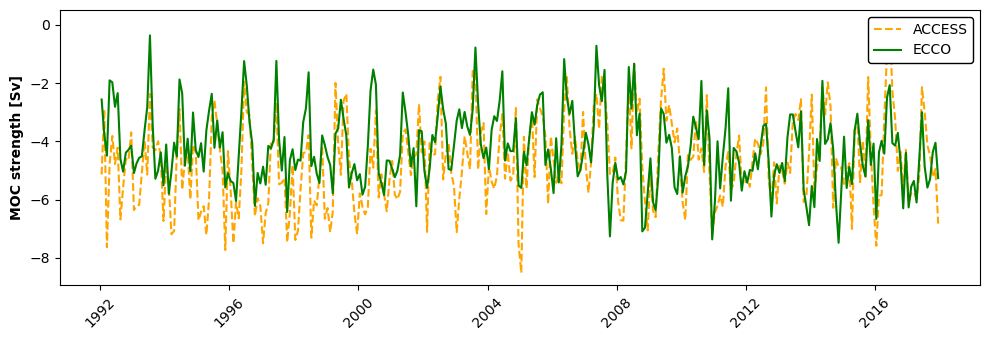

In [22]:
# Plot ECCO vs ACCESS
plt.figure(figsize = (10, 3.5))

plt.plot(moc_access["time"].squeeze(), moc_access["moc"].squeeze(), label='ACCESS', color="orange", linestyle='--', linewidth=1.5)
plt.plot(moc_ecco_latlon["time"].squeeze(), moc_ecco_latlon["moc"].squeeze(), color="green", label='ECCO', linewidth=1.5)  

plt.xticks(rotation=45)
plt.ylabel('MOC strength [Sv]', weight="bold")
plt.legend(loc = 'upper right', edgecolor = 'black', framealpha = 1, fontsize=10)
plt.tight_layout()
plt.savefig(f"C:/Users/aline/OTP/plots/ecco_vs_access.png", dpi=400)

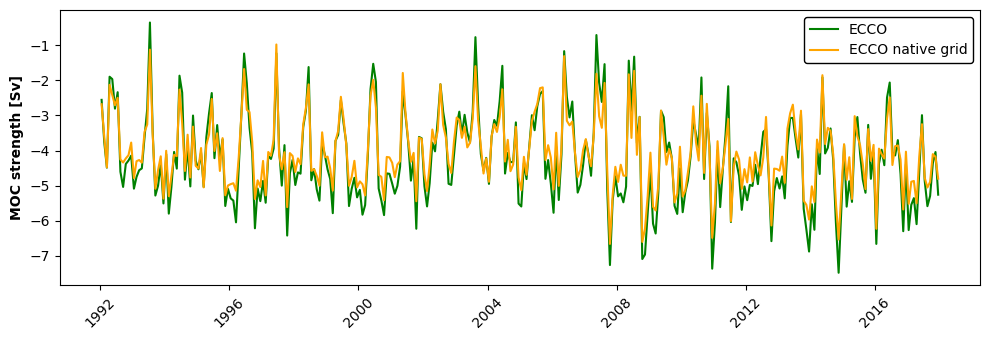

In [23]:
# Plot native grid vs latlon ECCO
plt.figure(figsize = (10, 3.5))

plt.plot(moc_ecco_latlon["time"].squeeze(), moc_ecco_latlon["moc"].squeeze(), color="green", label='ECCO', linewidth=1.5)  
plt.plot(moc_ecco_native["time"].squeeze(), moc_ecco_native["psi_moc"].squeeze(), color="orange", linestyle='-', label='ECCO native grid', linewidth=1.5) 

plt.xticks(rotation=45)
plt.ylabel('MOC strength [Sv]', weight="bold")
plt.legend(loc = 'upper right', edgecolor = 'black', framealpha = 1, fontsize=10)
plt.tight_layout()
plt.savefig(f"C:/Users/aline/OTP/plots/latlon_vs_nativegrid.png", dpi=400)